## Example: ptychographic reconstruction with position optimisations
This example uses simulated data, and tracks the positions changes vs the optimisation cycles

In [1]:
#import os
#os.environ['PYNX_PU'] = 'opencl'  # Select language and/or GPU name or rank through environment variable (optional)

%matplotlib notebook
import matplotlib.pyplot as plt
from pynx.ptycho import simulation, shape

# Import Ptycho, PtychoData and operators (automatically selecting OpenCL or CUDA)
from pynx.ptycho import *

/Users/vincent/dev/py36-env/lib/python3.6/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


## Simulate the Ptychographic data

In [2]:
n = 256
nb_frame = 120
pixel_size_detector = 55e-6
wavelength = 1.5e-10
detector_distance = 1
obj_info = {'type': 'phase_ampl', 'phase_stretch': np.pi, 'ampl_range': (0.8,1.2), 'alpha_win': .2}
probe_info = {'type': 'focus', 'aperture': (120e-6, 120e-6), 'focal_length': .08, 'defocus': 800e-6, 'shape': (n, n)}

# 50 scan positions correspond to 4 turns, 78 to 5 turns, 113 to 6 turns
scan_info = {'type': 'spiral', 'scan_step_pix': 30, 'n_scans': nb_frame, 'integer_values': False}
data_info = {'num_phot_max': 1e9, 'bg': 0, 'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector,
             'noise': 'poisson'}

# Initialisation of the simulation with specified parameters, specific <object>, <probe> or <scan>positions can be passed as:
# s = ptycho.Simulation(obj=<object>, probe=<probe>, scan = <scan>)
# omitting obj_info, probe_info or scan_info (or passing it as empty dictionary "{}")
s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)

# Data simulation: probe.show(), obj.show(), scan.show() and s.show_illumination_sum() will visualise the integrated total coverage of the beam
s.make_data()

posx, posy = s.scan.values

pixel_size_object = wavelength * detector_distance / pixel_size_detector / n

ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity

Simulating object: phase_ampl
Simulating probe: focus


Simulating scan: spiral
Simulating ptychographic data [120 frames].


Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': 1000000000.0, 'nb_photons_per_frame': 100000000.0, 'bg': 0, 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelength': 1.5e-10, 'detector_distance': 1, 'detector_pixel_size': 5.5e-05}
Scan info: {'type': 'spiral', 'scan_step_pix': 30, 'n_scans': 120, 'integer_values': False}
Object info: {'type': 'Custom', 'phase_stretch': 3.141592653589793, 'ampl_range': (0.8, 1.2), 'alpha_win': 0.2}
Probe info: {'type': 'focus', 'shape': (256, 256), 'sigma_pix': (50, 50), 'rotation': 0, 'aperture': (0.00012, 0.00012), 'focal_length': 0.08, 'defocus': 0.0008}


## Create the initial reconstructed object & probe
The initial object is random (amplitude between 0.5 and 1, phase between 0 and 0.5 radians), and the probe is different from the one used to simulate the diffraction patterns.

In [3]:
nyo, nxo = shape.calc_obj_shape(posx, posy, ampl.shape[1:])

# Initial object
# obj_init_info = {'type':'flat','shape':(nx,ny)}
obj_init_info = {'type': 'random', 'range': (0.5, 1, 0, 0.5), 'shape': (nyo, nxo)}
# Initial probe
probe_init_info = {'type': 'focus', 'aperture': (100e-6, 100e-6), 'focal_length': .08,
                   'defocus': 700e-6, 'shape': (n, n)}
data_info = {'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector}
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)

init.make_obj()
init.make_probe()

Simulating object: random
Simulating probe: focus


## Alter the positions & create the Ptycho object
We just alter two positions here, but more can be added.

The `p._interpolation` parameter can be used to trigger the use of interpolation - i.e. when a scan position does not correspond to an integer number of pixels, the object is interpolated with a bilinear approximation. Note that it is not necessary to use this interpolation to detetermine the 

In [4]:
posx1, posy1 = posx.copy(), posy.copy()
posx1[10] += 5
posy1[10] += 10
posx1[20] -= 5
posy1[20] -= 5

if False:
    posx1, posy1 = np.round(posx1), np.round(posy1)

data = PtychoData(iobs=ampl ** 2, positions=(posx1 * pixel_size_object, posy1 * pixel_size_object), 
                  detector_distance=1, mask=None, pixel_size_detector=55e-6, wavelength=1.5e-10)

p = Ptycho(probe=s.probe.values, obj=init.obj.values, data=data, background=None) # Random object start


# Use interpolation ?
p._interpolation = False

# Initial scaling of object and probe
p = ScaleObjProbe(verbose=True) * p

ScaleObjProbe: 4342.863 295954.7 86.14509457473032 76.6195900580897 1.1243220426332794


## Initial object and probe optimisation

<IPython.core.display.Javascript object>


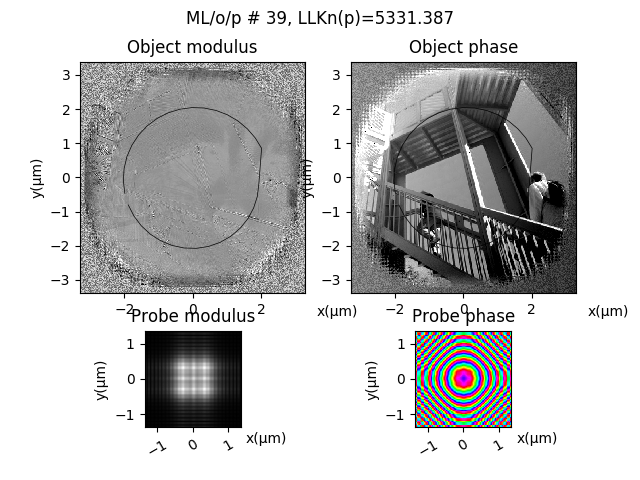

DM/o/p     #  0 LLK= 295546.13(p) 215965440.00(g) 467646.57(e), nb photons=2.364675e+13, dt/cycle=0.000s
DM/o/p     # 10 LLK= 33588.95(p) 2710081.33(g) 49970.79(e), nb photons=2.455268e+13, dt/cycle=0.040s
DM/o/p     # 20 LLK= 15072.41(p) 1504200.40(g) 24150.10(e), nb photons=2.471364e+13, dt/cycle=0.031s
DM/o/p     # 30 LLK= 17897.09(p) 1741727.60(g) 28502.77(e), nb photons=2.458710e+13, dt/cycle=0.030s
DM/o/p     # 39 LLK= 19853.53(p) 1530296.00(g) 31270.13(e), nb photons=2.449712e+13, dt/cycle=0.036s
AP/o       # 40 LLK= 19480.20(p) 1577403.87(g) 30761.39(e), nb photons=2.487737e+13, dt/cycle=0.212s
AP/o       # 50 LLK=  7187.00(p) 2676095.47(g) 14017.30(e), nb photons=2.485028e+13, dt/cycle=0.034s
AP/o       # 60 LLK=  6597.04(p) 2490441.60(g) 13018.82(e), nb photons=2.485207e+13, dt/cycle=0.025s
AP/o       # 70 LLK=  6299.24(p) 2377804.53(g) 12503.15(e), nb photons=2.485302e+13, dt/cycle=0.025s
AP/o       # 79 LLK=  6143.07(p) 2317552.00(g) 12228.53(e), nb photons=2.485352e+13, dt

In [5]:
plt.figure()
p = DM(update_object=True, update_probe=True, calc_llk=10, show_obj_probe=10)**40 * p
p = AP(update_object=True, update_probe=False, calc_llk=10, show_obj_probe=10)**40 * p
p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=10)**40 * p

## Optimise positions
This works best using AP or ML algorithms. DM tends to be more unstable.

We use the `pos_history` option so that we can plot the position history vs the cycle number later. It slows down the optimisation as data needs to be retreived from the GPU for each cycle.

<IPython.core.display.Javascript object>


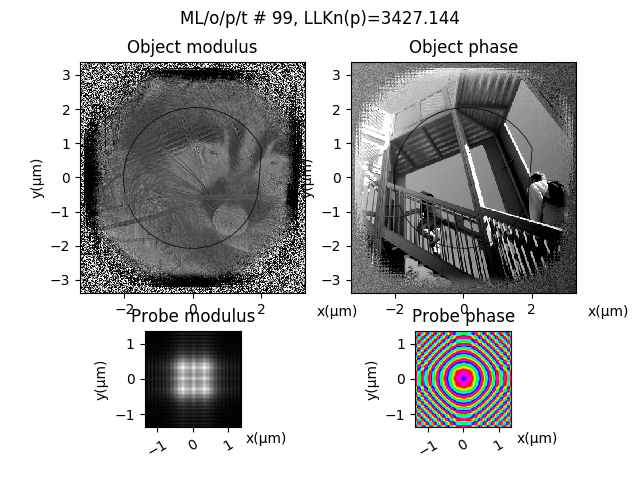

AP/o/p/t   #121 LLK=  5328.56(p) 2958766.93(g) 11141.71(e), nb photons=2.487755e+13, dt/cycle=0.308s
AP/o/p/t   #171 LLK=  1636.87(p) 702032.40(g)  3505.91(e), nb photons=2.488034e+13, dt/cycle=0.028s
AP/o/p/t   #221 LLK=  1495.89(p) 631076.87(g)  3233.02(e), nb photons=2.487308e+13, dt/cycle=0.027s
AP/o/p/t   #271 LLK=  1470.39(p) 601447.87(g)  3190.73(e), nb photons=2.485926e+13, dt/cycle=0.027s
AP/o/p/t   #321 LLK=  1439.69(p) 552219.47(g)  3135.95(e), nb photons=2.486600e+13, dt/cycle=0.027s
AP/o/p/t   #371 LLK=  1485.40(p) 521001.93(g)  3229.33(e), nb photons=2.486980e+13, dt/cycle=0.027s
AP/o/p/t   #421 LLK=  1931.97(p) 594979.33(g)  4119.77(e), nb photons=2.486649e+13, dt/cycle=0.027s
AP/o/p/t   #471 LLK=  1897.55(p) 582403.60(g)  4054.10(e), nb photons=2.488625e+13, dt/cycle=0.027s
AP/o/p/t   #521 LLK=  1983.83(p) 554161.93(g)  4229.44(e), nb photons=2.487913e+13, dt/cycle=0.027s
AP/o/p/t   #571 LLK=  2100.45(p) 553073.93(g)  4460.30(e), nb photons=2.486817e+13, dt/cycle=0.027s

In [6]:
plt.figure()  # Use a new figure
#p = ShowObjProbe() *DM(update_object=True, update_probe=True, update_pos=True,  pos_threshold=0.1,
#                       pos_min_shift=0.0, pos_max_shift=2, pos_history=True, calc_llk=20,
#                       show_obj_probe=20)**100 * p
p = ShowObjProbe() *AP(update_object=True, update_probe=True, update_pos=True, pos_threshold=0.1,
                       pos_min_shift=0.0, pos_max_shift=2, pos_history=True, calc_llk=50,
                       show_obj_probe=50)**500 * p
p = ShowObjProbe() * ML(update_object=True, update_probe=True, update_pos=True, 
                        pos_history=True, calc_llk=10, show_obj_probe=20)**100 * p


## Plot the position shifts
The recorded position shifts can be manually plotted

<IPython.core.display.Javascript object>


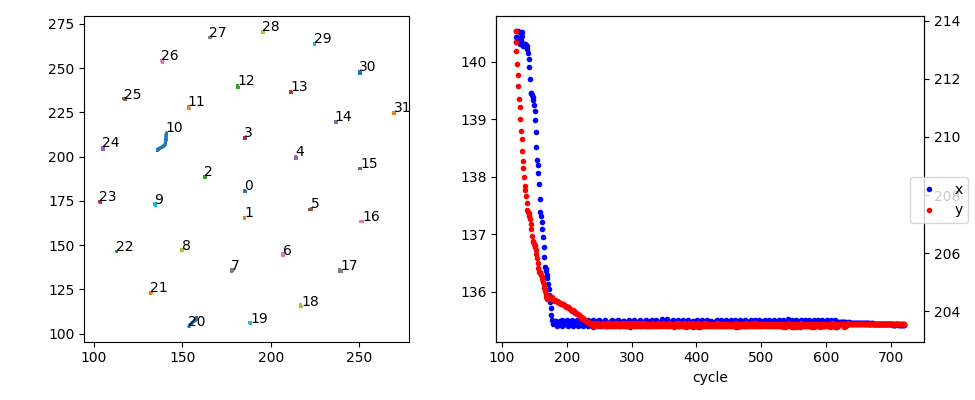

In [7]:
ipos = 10  # 10 or 20
fig = plt.figure(figsize=(9.75,4))
ax = plt.subplot(121)
#for i in range(default_processing_unit.get_stack_size()):
for i in range(32):
    x = [v[1] for v in p.position_history[i]]
    y = [v[2] for v in p.position_history[i]]
    plt.scatter(x,y, 1)
    plt.text(x[0], y[0], '%d' % i)
    #print("%3d  dr = %5.3f" % (i, np.sqrt((x[0]-x[-1])**2 + (y[0]-y[-1])**2)))
ax.set_aspect(1)

plt.subplot(122)
ix, x, y = [v[0] for v in p.position_history[ipos]], [v[1] for v in p.position_history[ipos]], \
           [v[2] for v in p.position_history[ipos]]
plt.plot(ix,x,'b.', label='x')
plt.xlabel('cycle')
plt.twinx()
plt.plot(ix,y,'r.', label='y')
fig.legend(loc="center right")
plt.tight_layout()